## Алгоритмы снижение размерности  
Далее на примерах я рассмотрю как работают выбранные алгоритмы снижение размерности, какие преимущества и недостатки есть у каждого и какие гиперпараметры на них нужно настраивать.  
Для начала скачаем данные, которые будем визуализировать  
### t-SNE (t-Distributed Stochastic Neighbor Embedding)  
Это метод сокращения размерности, используемый для представления высокомерного набора данных в низкоразмерном пространстве двух или трех измерений, для дальнейшей визуализации и ускорения обучения.  
В отличие от PCA это не математический метод, а вероятностный. В отличие от других алгоритмов уменьшения размерности, таких как PCA, которые просто максимизируют дисперсию, t-SNE создает уменьшенное пространство признаков, где сходные выборки моделируются близлежащими точками, а несходные выборки моделируются удаленными точками с высокой вероятностью.  
  
Ресурс: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

Рассмотрим все на примере датасета нарисованных цифр

In [2]:
mnist = fetch_openml("mnist_784")
X = mnist.data / 255.0
y = mnist.target

feat_cols = ['pixel' + str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X, columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

Так как здесь у нас лишь пример работы алгоритма, мы не будем использовать все 70.000 данных, а возьмем лишь случайные 10.000 цифр. Случайный выбор важен, так как в датасете объекты расположены по убыванию таргета.

In [3]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

Посмотрим, на что похожи наши рукописыне цифры

<Figure size 432x288 with 0 Axes>

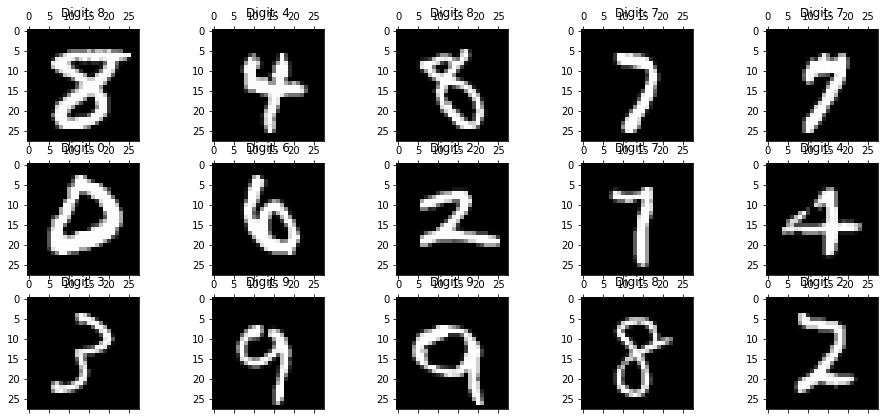

In [4]:
plt.gray()
fig = plt.figure(figsize=(16,7))
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

Все изображения имеют размер 28 на 28 пикселей и, следовательно, имеют в общей сложности 784 характеристики, каждое из которых содержит значение одного конкретного пикселя.

Что мы можем сделать, так это резко сократить число измерений, пытаясь сохранить как можно больше информации. Здесь мы переходим к уменьшению размерности. 
  
Попробуем оставить при помощи pca просто первые три компоненты и посмотрим, сколько информации они в себе хранят.

In [5]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


Теперь, учитывая, что первые два компонента составляют около 16% вариации во всем наборе данных, давайте посмотрим, достаточно ли этого, чтобы визуально отделить разные цифры друг от друга.

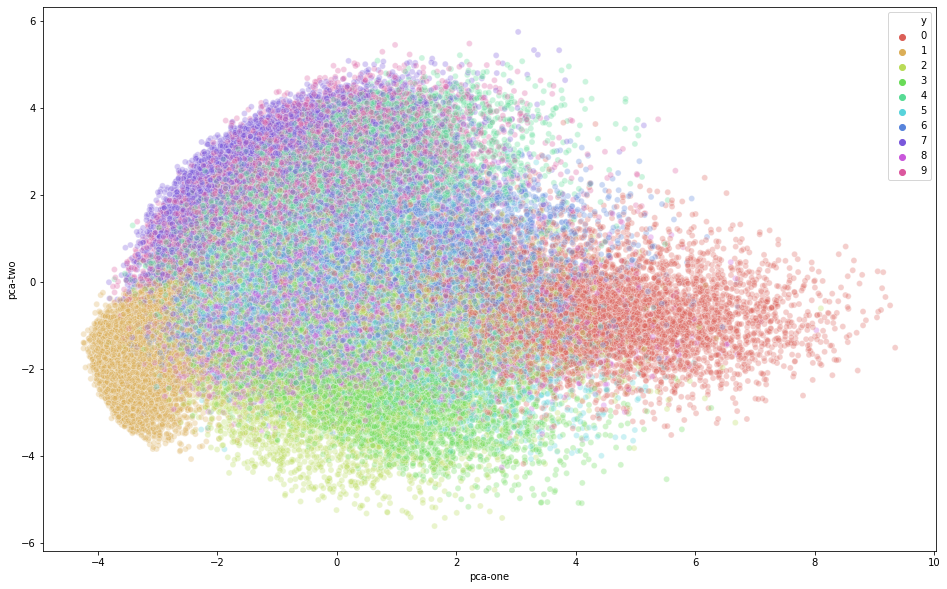

In [6]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

Из графика мы видим, что эти два компонента определенно содержат некоторую информацию, особенно для конкретных цифр, но явно недостаточно, чтобы отделить их все друг от друга. К счастью, есть еще один метод, который мы можем использовать, чтобы уменьшить количество измерений, которые могут оказаться более полезными. Метод, который мы будем исследовать, известен как t-SNE (t-Distributed Stochastic Neighbouring Entities).

Одна из рекомендаций при работе с T-SNE заключается в том, что в случае очень больших размреностей данныхследует прежде применить другой метод уменьшения размерности перед использованием t-SNE, т.к. иначе процесс может быть вычислительно долгим.  
  
Вопреки приведенной выше рекомендации, сначала попробуем запустить алгоритм на не сжатых данных (размерность 784) и посмотрим, как он работает.

In [10]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 3.156s...
[t-SNE] Computed neighbors for 10000 samples in 157.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.117975
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.840317
[t-SNE] KL divergence after 300 iterations: 2.803986
t-SNE done! Time elapse

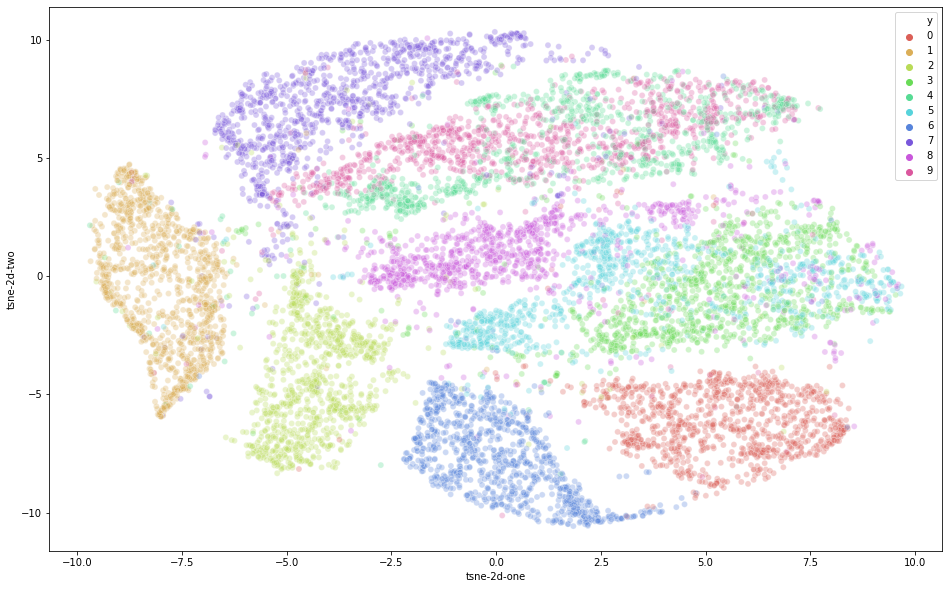

In [15]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Это уже значительное улучшение по сравнению с визуализацией PCA, которую мы использовали ранее. Мы видим, что цифры очень четко сгруппированы в свои собственные подгруппы. Если бы мы теперь использовали алгоритм кластеризации для выделения отдельных кластеров, мы, вероятно, могли бы довольно точно предсказать таргет.

Теперь мы примем рекомендации и уменьшим количество измерений при помощи PCA, прежде чем вводить данные в алгоритм t-SNE. Проведем эксперимент с разным количеством компонент.

In [13]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

pca_100 = PCA(n_components=100)
pca_result_100 = pca_100.fit_transform(data_subset)
print('Cumulative explained variation for 100 principal components: {}'.format(np.sum(pca_100.explained_variance_ratio_)))

pca_300 = PCA(n_components=300)
pca_result_300 = pca_300.fit_transform(data_subset)
print('Cumulative explained variation for 300 principal components: {}'.format(np.sum(pca_300.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8261665973784227
Cumulative explained variation for 100 principal components: 0.9156730586232606
Cumulative explained variation for 300 principal components: 0.9866907381405217


In [14]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)

time_start = time.time()
tsne_pca_results_50 = tsne.fit_transform(pca_result_50)
print('t-SNE on PCA_50 done! Time elapsed: {} seconds'.format(time.time()-time_start))

time_start = time.time()
tsne_pca_results_100 = tsne.fit_transform(pca_result_100)
print('t-SNE on PCA_100 done! Time elapsed: {} seconds'.format(time.time()-time_start))

time_start = time.time()
tsne_pca_results_300 = tsne.fit_transform(pca_result_300)
print('t-SNE on PCA_300 done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 41.62565565109253 seconds
t-SNE done! Time elapsed: 60.48520851135254 seconds
t-SNE done! Time elapsed: 104.13780760765076 seconds


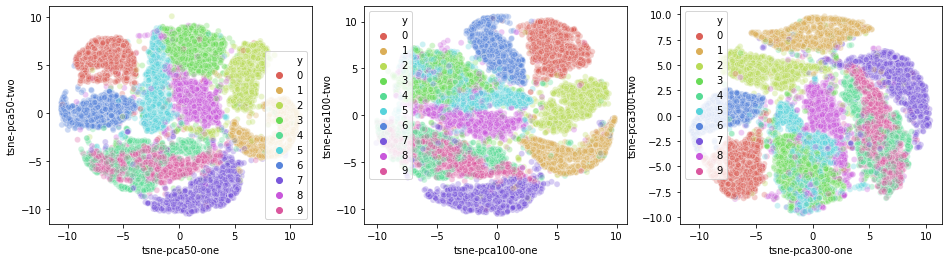

In [15]:
df_subset['tsne-pca50-one'] = tsne_pca_results_50[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results_50[:,1]
df_subset['tsne-pca100-one'] = tsne_pca_results_100[:,0]
df_subset['tsne-pca100-two'] = tsne_pca_results_100[:,1]
df_subset['tsne-pca300-one'] = tsne_pca_results_300[:,0]
df_subset['tsne-pca300-two'] = tsne_pca_results_300[:,1]

plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-pca100-one", y="tsne-pca100-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca300-one", y="tsne-pca300-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

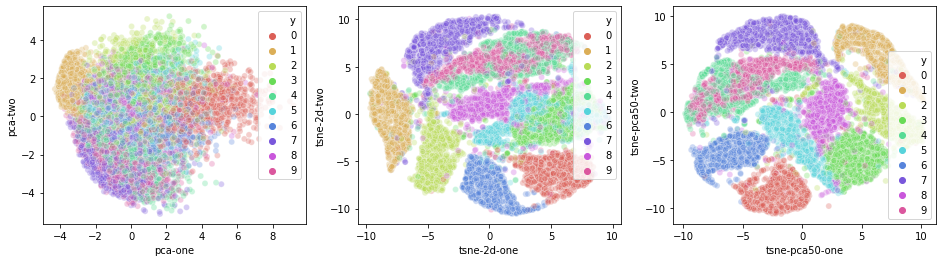

In [19]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

**Какой можно сделать вывод**  
t-SNE в плане разделения данных работает намного лучше, чем PCA. Однако этот способ сложнее и оттого затратнее по времени и мощностям. Во избежании долго времени обработки, можно для начала сократить размерность данных быстрым PCA, а затем применять t-SNE.  
Причем, как видно из этого примера, порой сократить можно приличное кол-во данных и при этом потеряется лишь 2-5% информации, что не так страшно. Например, мы сократили размерность с 784 до 100, при этом время работы t-SNE уменьшилось в 3 раза, однако результат не стал сильно хуже - кластеры все еще неплохо различимы и в каких-то местах даже лучше чем на PCA_50 и обычном t-SNE.